In [1]:
import os
import sys
module_path = sys.path.append('/home/dpirvu/.local/lib/python3.8/site-packages/')
module_path = sys.path.append('/home/dpirvu/.local/bin/')
for i in sys.path:
    i = i.replace("8", "7")
    if i not in sys.path:
        sys.path.append(i)
        print(i)
import numpy as np
import random
import math
import statistics as stat
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
import scipy.optimize as sco
import scipy.signal as scs
import scipy.special as ssp
import scipy.integrate as sci
from scipy import stats
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d
from uncertainties import ufloat

/home/dpirvu/.local/lib/python3.7/site-packages/


In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
nLat = 512
nTime = nLat
nTimemultiplier1 = 2
nTimemultiplier2 = 10

nSims = 100

phi0 = 1.
m2bare = 1.
lenLat = 100.
nCols = 2

nyq = nLat//2
spec = nyq

alpha = 8
dx = lenLat/nLat
dk = 2.*np.pi/lenLat
dt = dx/alpha
dtout = dt*alpha

### Theoretical Field PS 

In [4]:
sim_location = lambda nT, nL, gam, m2, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_t'+str(nT)+'_x'+str(nL)+'_gam'+str(gam)+'_m2{:.4f}'.format(m2)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
eff_sim_location = lambda nT, nL, gam, m2, tem, phi, lam, sim: '/gpfs/dpirvu/thermal_bubbles/phi4_meffPS_t'+str(nT)+'_x'+str(nL)+'_gam'+str(gam)+'_m2{:.4f}'.format(m2)+'_temp{:.4f}'.format(tem)+'_phi0{:.4f}'.format(phi)+'_lamb{:.4f}'.format(lam)+'_sim'+str(sim)+'_fields.dat'
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, gam, m2, tem, phi, lam, sim):
    nTT = nT*(nTimemultiplier1 if gam != 1 else nTimemultiplier2)
#    import_time_list = np.asarray(np.arange(nL).tolist() + np.arange(nTT-nL,nTT).tolist())
    import_time_list = np.arange(nTT-nL,nTT)
    data = np.genfromtxt(sim_location(nTT, nL, gam, m2, tem, phi, lam, sim))
    return np.asarray([np.reshape(data[:,col], (nTT, nL))[import_time_list] for col in range(nCols)])

def extract_sim_eff(nT, nL, gam, m2, tem, phi, lam, sim):
    nTT = nT*(nTimemultiplier1 if gam != 1 else nTimemultiplier2)
#    import_time_list = np.asarray(np.arange(nL).tolist() + np.arange(nTT-nL,nTT).tolist())
    import_time_list = np.arange(nTT-nL,nTT)
    data = np.genfromtxt(eff_sim_location(nTT, nL, gam, m2, tem, phi, lam, sim))
    return np.asarray([np.reshape(data[:,col], (nTT, nL))[import_time_list] for col in range(nCols)])

In [ ]:
# field spectrum
# prediction from lattice renormalization
freqs = np.fft.fftshift(np.fft.fftfreq(nLat, d=dx))*2*np.pi
norm = 1./ phi0 / np.sqrt(2.*lenLat)
omega = np.sqrt(freqs**2. + m2bare)

spectral_field = lambda tem: np.asarray([norm * np.sqrt(2./(np.exp(omega[k]/tem) - 1.)) / omega[k]**0.5 if k != nLat//2 else 0 for k in range(nLat)])
sigma0sq_th = lambda tem: np.sum( np.abs(spectral_field(tem))**2. )

V = lambda x, lam, gam: (0.5*m2bare*x**2. + lam*x**4./24.) if gam == 0. else (-0.5*m2bare*x**2. + lam*x**4./24.) if gam == 1. else (0.5*m2bare*x**2.)

### Extract data from files

In [ ]:
list_gamma = [0, 1]; print(list_gamma)
list_lamb = [0.1, 1, 10]; print(list_lamb)
list_temp = np.arange(1, 16, 1)[::4]; print(list_temp)

[0, 1]
[0.1, 1, 10]
[ 1  5  9 13]


In [ ]:
all_bare_data = np.asarray([[[[extract_sim(nTime, nLat, gamma, m2bare, temp, phi0, lamb, sim) for sim in range(nSims)] for gamma in list_gamma] for lamb in list_lamb] for temp in list_temp])
print('Done')

#all_eff_data = np.asarray([[[[extract_sim_eff(nTime, nLat, gamma, m2bare, temp, phi0, lamb, sim) for sim in range(nSims)] for gamma in list_gamma] for lamb in list_lamb] for temp in list_temp])
#print('Done')

all_data = np.asarray([all_bare_data])#, all_eff_data])

In [ ]:
for ggg, gamma in enumerate(list_gamma):
    print('gamma = ', gamma)
    for lll, lamb in enumerate(list_lamb):
        print('lamb = ', lamb)
        print(sigma0sq_th(list_temp).tolist())
        for ind, data in enumerate(all_data):
            print([np.mean([np.mean(data[ttt][lll][ggg][sim,0,0]**2.) for sim in range(nSims)], axis=0) for ttt in range(len(list_temp))])

In [ ]:
if False:
    gamma = list_gamma[0]
    lamb = list_lamb[0]
    sim = random.randint(0, nSims-1); print(sim)

    for ttt, temp in enumerate(list_temp):
        field = extract_sim(nTime, nLat, gamma, m2bare, temp, phi0, lamb, sim)[0]
        T, N = np.shape(field)
        PowSpec1 = np.abs(np.fft.fftshift(np.fft.fft2(field)))**2./N**2./T**2.
        PowSpec2 = np.abs(np.fft.fftshift(np.fft.ifft2(field)))**2.

        fig, ax = plt.subplots(1, 3, figsize = (25, 4))
        im = ax[0].imshow(field, aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im, ax = ax[0])
        im = ax[1].imshow(np.log(PowSpec1), aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im, ax = ax[1])
        im = ax[2].imshow(np.log(PowSpec2), aspect='auto', interpolation='none', origin='lower')
        clb = plt.colorbar(im, ax = ax[2])
        plt.suptitle('Temperature = '+str(temp))
        plt.show()

In [ ]:
if True:
    sim = random.randint(0, nSims-1); print('Simulation:',sim)

    for ind, data in enumerate(all_data):
        for ggg, gamma in enumerate(list_gamma):
            for lll, lamb in enumerate(list_lamb):
                fig, ax = plt.subplots(1, len(list_temp), figsize = (4*len(list_temp), 5))
                for ttt, temp in enumerate(list_temp):
                    im0 = ax[ttt].imshow(all_data[ind][ttt][lll][ggg][sim][0], aspect='auto', interpolation='none', origin='lower')
                    clb = plt.colorbar(im0, ax = ax[ttt])
                    ax[ttt].text(nLat-150, 2*nTime-120, f'$T = %5.0f$\n$\gamma = %5.0f$\n$\lambda = %5.1f$'%(temp, list_gamma[ggg], lamb), bbox={'facecolor': 'white', 'pad': 2})
                plt.show()

In [ ]:
# check power spectrum and sigma0 match
if True:
    for ggg, gamma in enumerate(list_gamma):
        for lll, lamb in enumerate(list_lamb):
            fig, ax = plt.subplots(1, 2, figsize = (15, 4))
    
            colors = cycle(('r', 'orange', 'y', 'g', 'b', 'purple'))
            for ttt, temp in enumerate(list_temp):
                for ind in range(len(all_data)):
                    col = next(colors)
                    list_time = np.arange(len(all_data[ind,ttt,lll,ggg,0,0]))
                    title = r'$T = %5.0f, \gamma = %5.0f, \lambda = %5.1f$'%(temp, gamma, lamb)
                    ax[0].plot(list_time, [np.mean(all_data[ind,ttt,lll,ggg][:,0,time]**2.) for time in list_time], marker='o', ms=1, color=col, label=title)
                ax[0].axhline(sigma0sq_th(temp), linestyle=':', color=col)
                ax[0].legend()
            ax[0].set_xlabel('Time')
            ax[0].set_ylabel(r'$\sigma_0^2(t)$')

            psmean_at0, sigma_at0, psmean_atnT, sigma_atnT = [], [], [], []
            for ind in range(len(all_data)):
                title = r'$\gamma = %5.0f, \lambda = %5.1f$'%(gamma, lamb)
                lsvec = cycle(('-', ':', '--'))
                colors = ['r', 'orange', 'y', 'g', 'b', 'purple']
                for time in np.arange(0, len(all_data[ind,ttt,lll,ggg,0,0]), nTime-1)[::-1]:
                    ax[1].plot(list_temp, [np.mean(all_data[ind,ttt,lll,ggg,:,0,time]**2.) for ttt in range(len(list_temp))], color=colors[-(time%(nTime-1))], linestyle=next(lsvec), alpha=0.5, label=title+' RMS at t='+str(time))
                    for ttt, temp in enumerate(list_temp):
                        ax[1].plot(temp, np.mean(all_data[ind,ttt,lll,ggg,:,0,time]**2.), color=colors[ttt], marker='o', ms=10)

            ax[1].plot(list_temp, sigma0sq_th(list_temp), color=colors[-1], label='th sigma')
            ax[1].set_xlabel('Temperature')
            ax[1].set_ylabel(r'$\sigma_0^2(T)$')
            ax[1].legend()
            ax[0].grid()
            ax[1].grid()
            plt.tight_layout()
            plt.show()

In [ ]:
def get_truncation_frequency(PowSpec, thresh):
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
#    kselect1 = np.sort(kk[kk>0])[0]
#    window_in_k1 = np.mean(PowSpec[:, kk==kselect1], axis=1)[(np.in1d(oo,kk))&(oo>0)]
    pick_freq_window = (kk>0)&(kk<thresh)
    window_in_k = np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)]
    smooth_window_in_k = gaussian_filter1d(window_in_k, sigma=1, mode='constant')
    try:
        minpeaks, properties = scs.find_peaks(-smooth_window_in_k, height=-max(smooth_window_in_k))
        minpeaks, height = minpeaks[0], -properties['peak_heights'][0]
        maxpeaks, properties = scs.find_peaks(smooth_window_in_k, height=min(smooth_window_in_k))
        if minpeaks < maxpeaks[properties['peak_heights']==max(properties['peak_heights'])]:
            return [minpeaks, height]
        else:
#            print('ValueError')
            raise ValueError
    except (ValueError, IndexError):
#        print('IndexError')
        minpeaks = 0
        height = smooth_window_in_k[minpeaks]
        return [minpeaks, height]

def get_pspec(data, lll, ggg, ttt, thresh):
    PowSpec = np.mean([np.abs(np.fft.fftshift(np.fft.ifft2(data[ttt][lll][ggg][sim][0])))**2. for sim in range(nSims)], axis=0)
    kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi

    pick_freq_window = (kk>0)&(kk<thresh)
#    print('averaged ks', kk[kk==pick_freq_window])
    pick_omega = np.sort(oo[oo>0])[0]
    return PowSpec, np.mean(PowSpec[:, kk==pick_freq_window], axis=1)[(np.in1d(oo,kk))&(oo>0)], PowSpec[oo==pick_omega, kk>0], oo[oo>0], kk[kk>0]

In [ ]:
if False:
    gamma = 0
    temp = -1
    lam = 0

    ii = 1
    for data in all_data:
        fig, ax = plt.subplots(1, 1, figsize = (15, 5))
        for time in np.linspace(nTime//10, nTime-20, 5):
            time = int(time)
            ii = ii - 0.17
            PDF1d = []
            for sim in range(nSims):
                for ttime in range(time, time+10):
                    PDF1d += data[temp][lam][gamma][sim][0][ttime].tolist()

            PDF1d = np.asarray(PDF1d)
            sigma, mu = np.std(PDF1d), np.mean(PDF1d); print(sigma, mu)
            n, bins, patches = plt.hist(PDF1d, bins=100, label='t = '+str(time), alpha=ii, ec='k', histtype='stepfilled')
            x = np.linspace(min(bins), max(bins), 500)
            gaussian = stats.norm.pdf(x, mu, sigma)

            k2, p = stats.normaltest(PDF1d)
            print("p = {:g}".format(p))
            alpha = 1e-3
            if p < alpha:  # null hypothesis: x comes from a normal distribution
                print("Field is not Gaussian.")
            else:
                print("Field may be Gaussian.")
        plt.legend()
        plt.show()

In [ ]:
def remove_walls(data, lam, gam, temp, sim, win):
    simulation = data[temp][lam][gam][sim][0]
    simulation = simulation - np.mean(simulation)
    fftfld = np.fft.fftshift(np.fft.ifft2(simulation))
    T, N = np.shape(fftfld)
    kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
    oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
    KK, OO = np.meshgrid(kk,oo)

    p1, p2, p3 = 1., 1., 0.5
    coords = ((KK/p1)**2. - (OO/p2)**2. <= -(p3)**2.)
    fftfld = fftfld*coords
    return kk, oo, fftfld, np.fft.ifft2(np.fft.ifftshift(fftfld)).real[win:nTime-win, win:nLat-win], simulation[win:nTime-win, win:nLat-win]

if False:
    for data in range(len(all_data)):
        for lam in range(len(list_lamb)):
            for gam in range(len(list_gamma)):
                sim = random.randint(0, nSims-1); print(sim)
                temp = -1
                win = 50
                lim = 3

                fig, ax = plt.subplots(1, 3, figsize = (20, 4))
                kfreqs, ofreqs, fftfld, sims_trunc, sims_orig = remove_walls(data, lam, gam, temp, sim, win)

                im = ax[0].imshow(np.log(np.abs(fftfld)**2.), aspect='auto', interpolation='none', origin='lower', extent=[kfreqs[0],kfreqs[-1],ofreqs[0],ofreqs[-1]])
                clb = plt.colorbar(im, ax = ax[0])
                ax[0].set_xlabel(r'$\bar{k}$'); ax[0].set_ylabel(r'$\bar{\omega_k}$')
                ax[0].set_ylim(0,lim); ax[0].set_xlim(0,lim)
                ax[0].set_title(f'$T = %5.2f, \gamma = %5.2f, \lambda = %5.2f$'%(list_temp[temp], list_gamma[gamma], list_lamb[lamb]))

                im = ax[1].imshow(sims_orig, aspect='auto', interpolation='none', origin='lower')
                im = ax[2].imshow(sims_trunc, aspect='auto', interpolation='none', origin='lower')
                clb = plt.colorbar(im, ax = ax[1]); clb = plt.colorbar(im, ax = ax[2])
                ax[1].set_title('Original'); ax[2].set_title('Cleaned walls')

                [i.set_xlabel(r'$x$') for i in ax[1:]]
                [i.set_ylabel(r'$t$') for i in ax[1:]]
                plt.show()

In [ ]:
# get mass best fit
omega_fit = lambda k, m: k**2. + m

def get_masses(data, bool, bool2, multiplier, lll, lamb, ggg, gamma):
    masses = []
    if bool2 and lll == 1: fig, ax = plt.subplots(1, len(list_temp), figsize = (5*len(list_temp), 4))

    for ttt, temp in enumerate(list_temp):
        PowSpec = np.mean(np.abs(np.fft.fftshift(np.fft.ifft2(data[ttt][lll][ggg][:,0])))**2., axis=0)
        kk = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[1], d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(np.shape(PowSpec)[0], d=dtout))*2*np.pi
        KK, OO = np.meshgrid(kk,oo)

        if bool2 and lll == 1:
            lim = 5
            exts = [kk[np.abs(kk)<=lim][0],kk[np.abs(kk)<=lim][-1],oo[(0<=oo)&(oo<=lim)][0],oo[(0<oo)&(oo<lim)][-1]]
            im = ax[ttt].imshow(np.log(PowSpec[:, (np.abs(kk)<lim)][(0<=oo)&(oo<=lim)]), aspect='auto', interpolation='none', origin='lower', extent=exts)
            clb = plt.colorbar(im, ax = ax[ttt])
            clb.set_label(r'$|\phi_k|^2$')
            ax[ttt].text(1.2, 4.7, r'$T = %5.0f, \lambda = %5.1f$'%(temp, lamb), bbox={'facecolor': 'white', 'pad': 5})
            ax[ttt].set_xlabel(r'$\bar{k}$')
            ax[ttt].set_ylabel(r'$\bar{\omega_k}$')
            ax[ttt].axvline(0, color='white', ls=':')
        
        trunc_freq, trunc_amp = get_truncation_frequency(PowSpec, thresh)
        PowSpec = PowSpec*(np.abs(OO) >= oo[oo>0][trunc_freq])
        osccoords = np.argwhere(PowSpec > max(trunc_amp, np.mean(PowSpec) + multiplier * np.std(PowSpec)))

        popt, pcov = sco.curve_fit(omega_fit, kk[osccoords[:,1]], oo[osccoords[:,0]]**2.)
        if popt[-1] < 0: masses.append('nan')
        else: masses.append(popt[-1])

        if bool:
            lim = max(freqs)
            fig, ax = plt.subplots(1, 2, figsize = (16, 4))
            ax[0].plot(kk[osccoords[:,1]], oo[osccoords[:,0]], 'o', ms=5, label='freqs')
            ax[0].plot(kk, np.sqrt(omega_fit(kk,*popt)), label=f'$T = %5.0f, m^2 = %5.2f$'%(temp, popt[-1]))
            ax[0].set_xlim(-lim,lim)
            ax[0].set_ylim(0,lim)
            ax[0].axhline(popt[-1], color='darkgray', ls=':', label='best fit')
            ax[0].axhline(m2bare, color='darkgray', ls='-.', label='potential mass')
            ax[0].legend()

            lim = 3
            ax[1].plot(kk, np.sqrt(omega_fit(kk,*popt)), color = 'y', label=f'$T = %5.2f, m^2 = %5.2f$'%(temp, popt[-1]))
            exts = [kk[np.abs(kk)<lim][0],kk[np.abs(kk)<lim][-1],oo[(0<oo)&(oo<lim)][0],oo[(0<oo)&(oo<lim)][-1]]
            im = ax[1].imshow(PowSpec[:, (np.abs(kk)<lim)][(0<oo)&(oo<lim)], aspect='auto', interpolation='none', origin='lower', extent=exts)
            clb = plt.colorbar(im, ax = ax[1])
            ax[1].set_title(f'$T = %5.0f, \gamma = %5.0f, \lambda = %5.1f$'%(temp, gamma, lamb))
            ax[1].set_xlabel(r'$\bar{k}$')
            ax[1].set_ylabel(r'$\bar{\omega_k}$')
            ax[1].axvline(0, color='white', ls=':')
            ax[1].axhline(0, color='white', ls=':')
            [i.legend() for i in ax]
            plt.show()
    return masses

### Checking if constants match

In [ ]:
multiplier = 10
thresh = 0.1

for ggg, gamma in enumerate(list_gamma):
    fig, ax = plt.subplots(1, len(list_lamb), figsize = (25,4), sharey=False)
    plt.subplots_adjust(hspace=0)
    for ind, data in enumerate(all_data):
        for lll, lamb in enumerate(list_lamb):
            ax[lll].plot(list_temp, get_masses(data, False, True, multiplier, lll, lamb, ggg, gamma), color='r', marker='o', ms=5, linestyle=':')

            m2_from_PS = (-m2bare if gamma == 1 else m2bare) + 0.5*lamb*sigma0sq_th(list_temp)
            ax[lll].plot(list_temp, np.abs(m2_from_PS), color='g', marker='*', linestyle='-')
            list_titles = [f'dispersion relation', 'prediction from PS']

            ax[lll].legend(title=r'$\gamma = %5.0f, \; \lambda = %5.1f$'%(gamma, lamb), loc='upper left')
            ax[lll].grid(color='darkgray', linestyle='-', linewidth=0.2)
            ax[lll].set_ylabel(r'$m_{eff}^2$')
            ax[lll].set_xlabel(f'$Temperature$')
        ax[0].legend(list_titles, title=r'$\gamma = %5.0f, \; \lambda = %5.1f$'%(gamma, list_lamb[0]), loc='upper left')
    plt.tight_layout()
    plt.show()

### Get profile of omega ^2

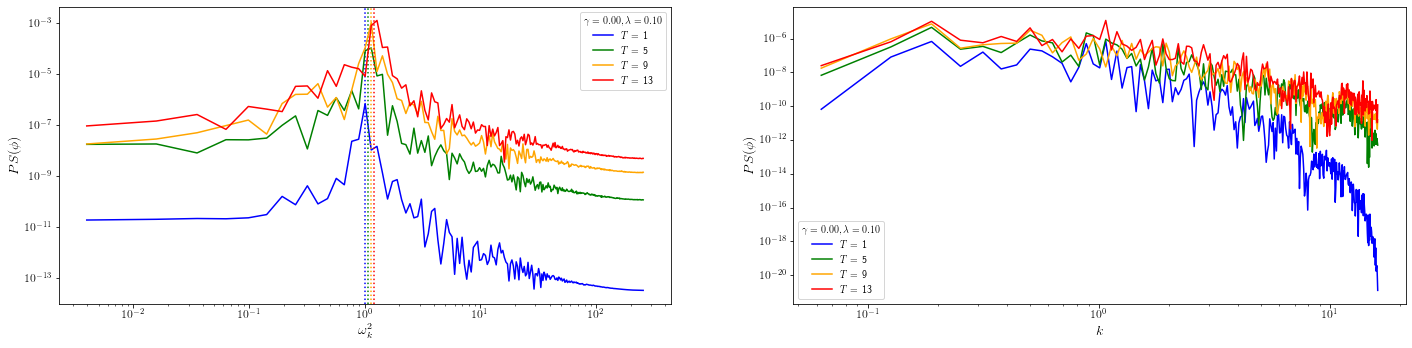

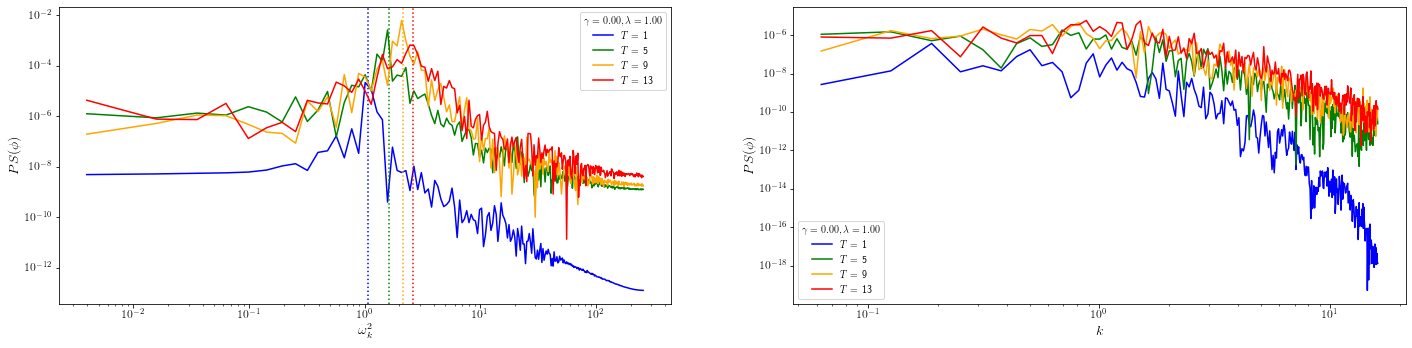

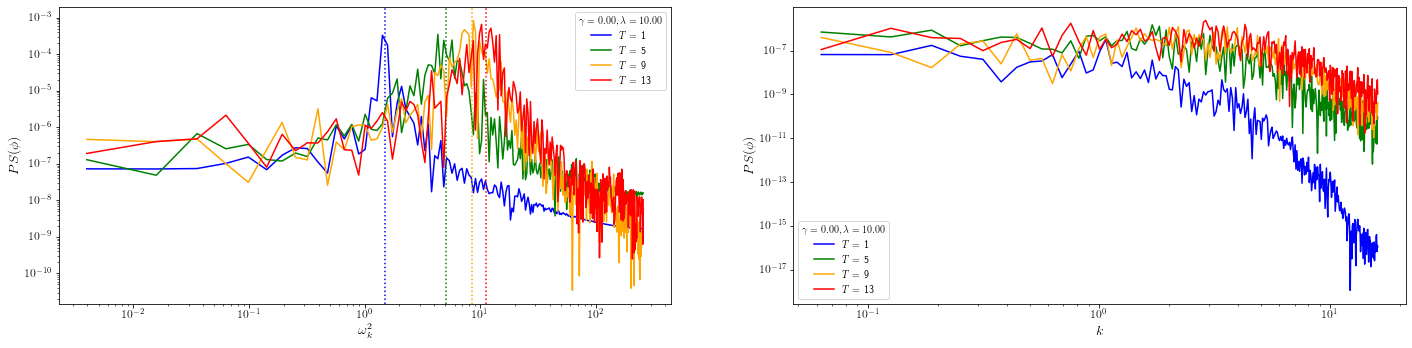

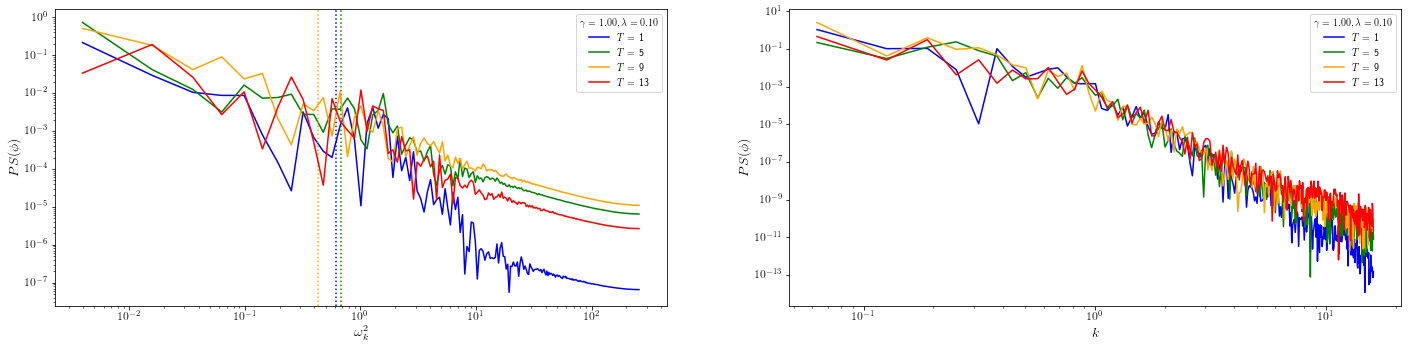

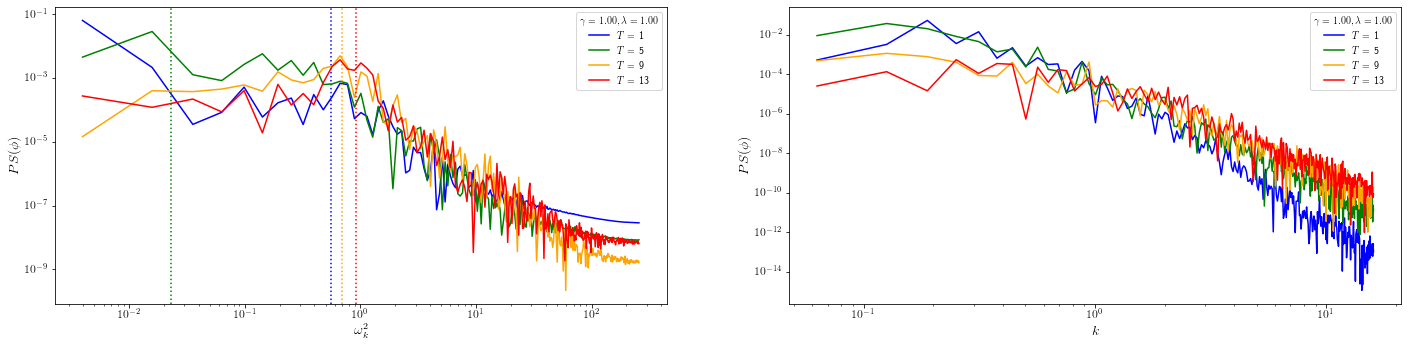

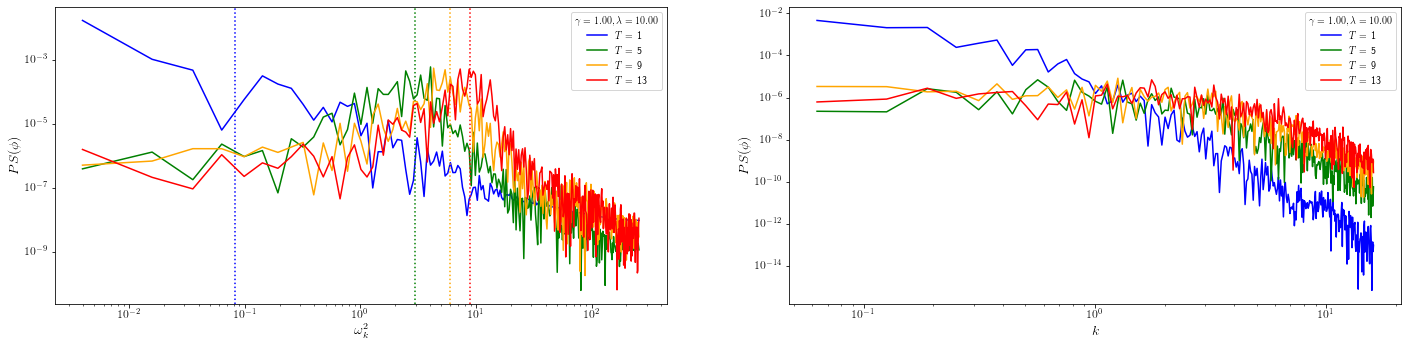

In [116]:
for ind, data in enumerate(all_data):
    for ggg, gamma in enumerate(list_gamma):
        for lll, lamb in enumerate(list_lamb):
            data_mass = get_masses(data, False, False, multiplier, lll, lamb, ggg, gamma)

            colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))
            fig, ax = plt.subplots(1, 2, figsize = (25, 5))
            for ttt, temp in enumerate(list_temp):
                col = next(colors)

                pspec, window_in_k, fix_omega, oo, kk = get_pspec(data, lll, ggg, ttt, thresh)

                smooth_window_in_k = gaussian_filter1d(window_in_k, sigma=0.8, mode='constant')
                peaks = scs.find_peaks(-smooth_window_in_k)
                if len(peaks[0]) > 0:
                    peak = peaks[0][0]
#                    ax[0].plot(kk[peak]**2., smooth_window_in_k[peak], "*", color=col, ms=10, alpha=0.5)
                else:
                    print('no truncation')
                ax[0].plot(kk**2., window_in_k, label=f'$T$ = '+str(temp), color=col)
                ax[0].axvline(data_mass[ttt], color=col, ls=':')

                ax[1].plot(kk, fix_omega, label=f'$T$ = '+str(temp), color=col)

                ax[0].set_xlabel(f'$\omega_k^2$')
                ax[1].set_xlabel(f'$k$')

            for ii in ax:
                ii.set_xscale('log')
                ii.set_yscale('log')
                ii.set_ylabel(f'$PS(\phi)$')
                ii.legend(title=f'$\gamma = %5.2f, \lambda = %5.2f$'%(gamma, lamb))
            plt.show()

### Separate Real and Imaginary Contributions to PSwindow_in_k

In [117]:
def get_masses_seps(data, bool, multiplier, lll, lamb, ggg, gamma, thresh):
    fullmasses, remasses, immasses = [], [], []
    for ttt, temp in enumerate(list_temp):
        fullPowSpec, rePowSpec, imPowSpec = [], [], []
        for sim in range(nSims):
            fftfield = np.fft.fftshift(np.fft.ifft2(data[ttt][lll][ggg][sim][0]))
            fullPowSpec.append(np.abs(fftfield)**2.)
            rePowSpec.append(np.abs(fftfield.real)**2.)
            imPowSpec.append(np.abs(fftfield.imag)**2.)
        fullPowSpec, rePowSpec, imPowSpec = np.mean(fullPowSpec, axis = 0), np.mean(rePowSpec, axis = 0), np.mean(imPowSpec, axis = 0)
        T, N = np.shape(fullPowSpec)
        kk = np.fft.fftshift(np.fft.fftfreq(N, d=dx))*2*np.pi
        oo = np.fft.fftshift(np.fft.fftfreq(T, d=dtout))*2*np.pi
        KK, OO = np.meshgrid(kk,oo)

        full_trunc_freq, full_trunc_amp = get_truncation_frequency(fullPowSpec, thresh)
        re_trunc_freq, re_trunc_amp = get_truncation_frequency(rePowSpec, thresh)
        im_trunc_freq, im_trunc_amp = get_truncation_frequency(imPowSpec, thresh)

        fullPowSpec = fullPowSpec*(np.abs(OO) >= oo[oo>0][full_trunc_freq])
        rePowSpec = rePowSpec*(np.abs(OO) >= oo[oo>0][full_trunc_freq])
        imPowSpec = imPowSpec*(np.abs(OO) >= oo[oo>0][full_trunc_freq])
#        rePowSpec = rePowSpec*(np.abs(OO) >= oo[oo>0][re_trunc_freq])
#        imPowSpec = imPowSpec*(np.abs(OO) >= oo[oo>0][im_trunc_freq])

        fullosccoords = np.argwhere(fullPowSpec > max(full_trunc_amp, np.mean(fullPowSpec) + multiplier * np.std(fullPowSpec)))
        reosccoords = np.argwhere(rePowSpec > max(full_trunc_amp, np.mean(rePowSpec) + multiplier * np.std(rePowSpec)))
        imosccoords = np.argwhere(imPowSpec > max(full_trunc_amp, np.mean(imPowSpec) + multiplier * np.std(imPowSpec)))
#        reosccoords = np.argwhere(rePowSpec > max(re_trunc_amp, np.mean(rePowSpec) + multiplier * np.std(rePowSpec)))
#        imosccoords = np.argwhere(imPowSpec > max(im_trunc_amp, np.mean(imPowSpec) + multiplier * np.std(imPowSpec)))

        fullmasses.append(sco.curve_fit(omega_fit, kk[fullosccoords[:,1]], oo[fullosccoords[:,0]]**2.)[0])
        remasses.append(sco.curve_fit(omega_fit, kk[reosccoords[:,1]], oo[reosccoords[:,0]]**2.)[0])
        immasses.append(sco.curve_fit(omega_fit, kk[imosccoords[:,1]], oo[imosccoords[:,0]]**2.)[0])

        coords = np.asarray([fullosccoords, reosccoords, imosccoords])
        PowSpecs = np.asarray([fullPowSpec, rePowSpec, imPowSpec])
        allMasses = np.asarray([fullmasses, remasses, immasses])
        title = ['Full, ', 'Real, ', 'Imag, ']
        if bool:
            fig, ax = plt.subplots(1, 2*len(allMasses), figsize = (25, 4))
            for iii, masses in enumerate(allMasses):
                lim = max(freqs)/2.
                ax[2*iii].plot(kk[coords[iii][:,1]], oo[coords[iii][:,0]], 'o', ms=5, label='valid points')
                ax[2*iii].plot(kk, np.sqrt(omega_fit(kk,masses[-1])), label=f'$m^2 = %5.5f$'%(masses[-1]))
                ax[2*iii].set_title(title[iii]+f'$T = %5.2f, \gamma = %5.2f, \lambda = %5.2f$'%(temp, gamma, lamb))
                ax[2*iii].axhline(np.sqrt(masses[-1]), color='darkgray', ls=':', label='best fit')

                [op.set_xlim(-lim,lim) for op in ax[::2]]
                [op.set_ylim(0,lim) for op in ax[::2]]

                lim = 5
                ax[2*iii+1].plot(kk, np.sqrt(omega_fit(kk,masses[-1])), color = 'y', label=f'$m^2 = %5.5f$'%(masses[-1]))
                im = ax[2*iii+1].imshow(np.log(PowSpecs[iii]), aspect='auto', interpolation='none', origin='lower', extent=[kk[0],kk[-1],oo[0],oo[-1]])
                clb = plt.colorbar(im, ax = ax[2*iii+1])

                [opp.set_xlabel(r'$\bar{k}$') for opp in ax[1::2]]
                [opp.set_ylabel(r'$\bar{\omega_k}$') for opp in ax[1::2]]
                [opp.set_xlim(-lim,lim) for opp in ax[1::2]]
                [opp.set_ylim(0,lim) for opp in ax[1::2]]
                [opp.axvline(0, color='white', ls=':') for opp in ax[1::2]]
            [op.legend(loc='upper center') for op in ax]
            plt.show()
    return allMasses

In [118]:
if False:
    for ind, data in enumerate(all_data):
        for ggg, gamma in enumerate(list_gamma):
            for lll, lamb in enumerate(list_lamb):
                allMasses = get_masses_seps(data, False, multiplier, lll, lamb, ggg, gamma, thresh)

                fig, ax = plt.subplots(1, 1, figsize=(8, 4))
                colors = cycle(('r', 'orange', 'y', 'g', 'b', 'm'))
                title = ['Full, ', 'Real, ', 'Imag, ']
                for iii, masses in enumerate(allMasses):
                    plt.plot(list_temp, masses, marker='o', linestyle='-', color=next(colors), label=title[iii]+f'$\gamma = %5.2f, \lambda = %5.2f$'%(gamma, lamb))

                for ijk in [ax]:
    #                ijk.plot(list_temp, np.abs((-m2bare if gamma == 1 else m2bare) + 0.5*lamb*sigma0sq_th(list_temp)), ':', color=next(colors), label='prediction from PS')
                    list_m2_eff_at_nTime = np.abs(np.asarray([(-m2bare if gamma == 1 else m2bare) + 0.5*lamb*np.mean(data[ttt][lll][ggg][:,0,-1]**2.) for ttt in range(len(list_temp))]))
    #                ijk.plot(list_temp, list_m2_eff_at_nTime, color=next(colors), linestyle='-.', label='prediction for $t=t_f$')

                    ijk.axhline(m2bare, color='darkgray', ls='--', label='potential mass')
                    ijk.set_title(f'multiplier = %5.0f, $\gamma = %5.2f, \lambda = %5.2f$'%(multiplier, gamma, lamb))
                    ijk.set_ylabel(f'$m^2(T, \gamma, \lambda)$')
                    ijk.set_xlabel(f'$T$')
                    ijk.legend()
                plt.show()